# Libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from torchsom.core import TorchSOM
from torchsom.plotting import SOMVisualizer, VisualizationConfig

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    f1_score, 
    accuracy_score, 
    recall_score, 
    precision_score, 
    confusion_matrix, 
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

In [2]:
random_seed = 42
torch.manual_seed(random_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing 

In [3]:
iris_df = pd.read_csv(
    filepath_or_buffer="../data/iris.csv",
)

In [4]:
feature_columns = iris_df.columns[:-1]  
scaler = StandardScaler()
iris_df[feature_columns] = scaler.fit_transform(iris_df[feature_columns])

In [5]:
iris_df['Species'] = iris_df['Species'].map({
    'Iris-setosa': 1, 
    'Iris-versicolor': 2, 
    'Iris-virginica': 3}
)

In [6]:
iris_df.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Species
0,-0.900681,1.032057,-1.341272,-1.312977,1
1,-1.143017,-0.124958,-1.341272,-1.312977,1
2,-1.385353,0.337848,-1.398138,-1.312977,1
3,-1.506521,0.106445,-1.284407,-1.312977,1
4,-1.021849,1.263460,-1.341272,-1.312977,1


In [7]:
iris_df.describe()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Species
count,1.500000e+02,1.500000e+02,1.500000e+02,1.500000e+02,150.000000
mean,-4.736952e-16,-6.631732e-16,3.315866e-16,-2.842171e-16,2.000000
std,1.003350e+00,1.003350e+00,1.003350e+00,1.003350e+00,0.819232
min,-1.870024e+00,-2.438987e+00,-1.568735e+00,-1.444450e+00,1.000000
25%,-9.006812e-01,-5.877635e-01,-1.227541e+00,-1.181504e+00,1.000000
50%,-5.250608e-02,-1.249576e-01,3.362659e-01,1.332259e-01,2.000000
75%,6.745011e-01,5.692513e-01,7.627586e-01,7.905908e-01,3.000000
max,2.492019e+00,3.114684e+00,1.786341e+00,1.710902e+00,3.000000


In [8]:
feature_names = feature_columns.to_list()
feature_names

['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']

In [9]:
iris_df.shape

(150, 5)

In [10]:
"""
1. Create a tensor from the iris df and separate the features and the target
2. Randomly shuffle the data
3. Split the data into training and testing sets
"""
iris_torch = torch.tensor(iris_df.to_numpy(dtype=np.float32))
all_features, all_targets = iris_torch[:, :4], iris_torch[:, 4].long()


shuffled_indices = torch.randperm(len(all_features))
all_features, all_targets = all_features[shuffled_indices], all_targets[shuffled_indices]

train_ratio = 0.8
train_count = int(train_ratio * len(all_features))
train_features, train_targets = all_features[:train_count], all_targets[:train_count]
test_features, test_targets = all_features[train_count:], all_targets[train_count:]

print(train_features.shape, test_features.shape)
print(train_targets.shape, test_targets.shape)

torch.Size([120, 4]) torch.Size([30, 4])
torch.Size([120]) torch.Size([30])


# TorchSOM

In [11]:
som = TorchSOM(
    x=25,
    y=15,
    sigma=1.45,
    learning_rate=0.95,
    neighborhood_order=3,
    epochs=100,
    batch_size=16,
    topology="rectangular",
    distance_function="euclidean",
    neighborhood_function="gaussian",
    num_features=all_features.shape[1],
    lr_decay_function="asymptotic_decay",
    sigma_decay_function="asymptotic_decay",
    initialization_mode="pca",
    device=device,
    random_seed=random_seed,
) 

In [12]:
som.initialize_weights(
    data=train_features,
)

In [13]:
QE, TE = som.fit(
    data=train_features
)

Training SOM: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.10epoch/s]


In [14]:
visualizer = SOMVisualizer(som=som, config=None)
save_path = "results/iris" # Set to None if you want a direct plot

In [15]:
visualizer.plot_training_errors(
    quantization_errors=QE, 
    topographic_errors=TE, 
    save_path=save_path
)

In [16]:
visualizer.plot_distance_map(save_path=save_path)

In [17]:
visualizer.plot_hit_map(
    data=train_features,
    save_path=save_path
)

In [18]:
visualizer.plot_classification_map(
    data=train_features,
    target=train_targets,
    save_path=save_path
)

In [19]:
visualizer.plot_component_planes(
    component_names=feature_names,
    save_path=save_path
)

# Prediction
Here, we do not add the testing samples in the SOM BMUs map.  
In forecasting or process control, it is interesting to add overtime the new elements in the SOM and potentially to update/refit it with a certain frequency.

In [20]:
predictions = []
bmus_idx_map = som.build_bmus_data_map(
    data=train_features,
    return_indices=True,  # False means we want the features of each sample and not the indices
)
for idx, (test_feature, test_target) in enumerate(zip(test_features, test_targets)):
    
    collected_features, collected_targets = som.collect_samples(
        query_sample=test_feature,
        historical_samples=train_features,
        historical_outputs=train_targets,
        min_buffer_threshold=30, # Collect 20 historical samples to train a model
        bmus_idx_map=bmus_idx_map,
    )
    
    X = collected_features.cpu().numpy()
    y = collected_targets.cpu().numpy().ravel()
    test_feature_np = test_feature.cpu().numpy().reshape(1, -1)  
    
    clf = MLPClassifier(
        hidden_layer_sizes=(8),
        max_iter=200,
        learning_rate_init=0.008,
        activation="relu",
        solver="adam",
        batch_size='auto', 
        random_state=random_seed,
        shuffle=True,
        verbose=False,
    ).fit(X, y)
    
    # plt.plot(clf.loss_curve_)
    # plt.xlabel("Iteration")
    # plt.ylabel("Loss")
    # plt.title("MLPClassifier Training Loss Curve")
    # plt.grid(True)
    # plt.show()
    
    clf_prediction = clf.predict(test_feature_np)
    predictions.append(clf_prediction[0]) 

In [21]:
y_pred = np.array(predictions)
y_true = test_targets.numpy()

# accuracy = accuracy_score(y_true, y_pred)
# precision = precision_score(y_true, y_pred, average='macro') # or 'weighted' or 'micro'
# recall = recall_score(y_true, y_pred, average='macro')
# f1 = f1_score(y_true, y_pred, average='macro') # or 'weighted' or 'micro'

# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall (Rappel): {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")

In [22]:
class_report = classification_report(y_true, y_pred)
print('\t\t\tClassification report:\n\n', class_report, '\n')

			Classification report:

               precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       0.90      0.90      0.90        10
           3       0.93      0.93      0.93        14

    accuracy                           0.93        30
   macro avg       0.94      0.94      0.94        30
weighted avg       0.93      0.93      0.93        30
 



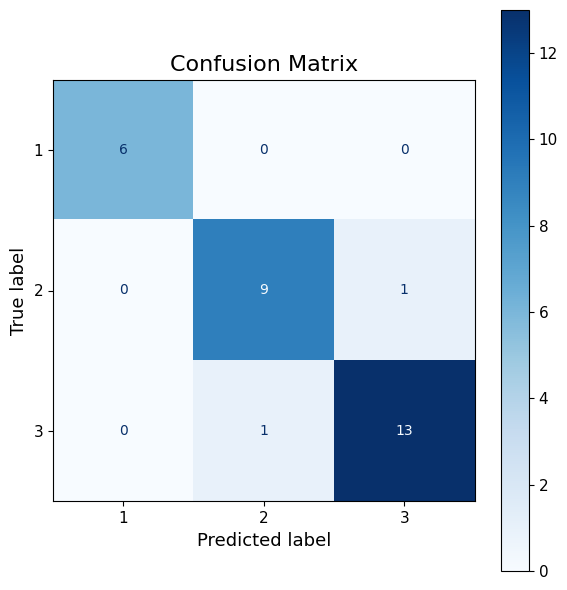

In [23]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()